# [E-01]RockPaperScissor

In [1]:
from PIL import Image
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

### Why use 'PIL library'?
* 가위바위보 데이터 이미지의 크기는 224 X 224.
* 데이터 이미지의 크기를 28 x 28 로 줄여야 함.
* 이를 위해, PIL 라이브러리를 사용

---

### glob
* 파일들의 리스트를 뽑을 때 사용.
* 와일드카드 문자를 사용해서 일정한 패턴을 가진 파일 이름들을 지정하기 위한 패턴
* 아래의 resize_images 함수에서 /*.jpg에 해당하는 파일들을 리스트로 images 변수에 저장

---
### numpy
* load_data 함수에서 numpy를 이용하여 이미지 데이터를 담을 행렬을 생성

---
### matplotlib
* training set에 저장되어 있는 이미지의 resize가 잘 이루어졌는지, 이미지에 다른 문제는 없는지 확인하기 위해서, matplotlib을 이용하여 이미지를 출력할 예정

# 1. 데이터 준비

In [2]:
def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")
    
    print(len(images), " images to be resized.")
    
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")

### resize_images(img_path)

1. glob 모듈을 이용하여, 매개변수 img_path 내부에 있는 '/*.jpg' 형식의 모든 파일을 리스트의 형식으로 images 변수에 저장
2. resize를 원하는 이미지 크기가 (28 X 28)이므로, target_size 변수에 저장
3. 이후 for문을 이용하여 images 리스트에 있는 모든 파일(jpg 파일)의 사이즈를 (28 X 28)로 바꾸고, new_img 라는 변수에 저장 (resize 메소드 사용)
4. 이때 사용한 ANTIALIAS는, anti-aliasing의 줄임말로, 높은 해상도의 신호를 낮은 해상도에서 나타낼 때 생기는 계단 현상(깨진 패턴)을 최소화하는 방법

In [3]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/scissor"
resize_images(image_dir_path)
print("Scissor image resized (28 X 28)")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/rock"
resize_images(image_dir_path)
print("Rock image resized (28 X 28)")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train/paper"
resize_images(image_dir_path)
print("Paper image resized (28 X 28)")

1500  images to be resized.
1500  images resized.
Scissor image resized (28 X 28)
1500  images to be resized.
1500  images resized.
Rock image resized (28 X 28)
1500  images to be resized.
1500  images resized.
Paper image resized (28 X 28)


## 이미지 크기 변경
* training set으로 사용할 이미지들의 크기를 (28 X 28)로 변경 (가위, 바위, 보)
* os.getenv: 환경변수 가져오기

In [4]:
def load_data(img_path, number_of_data=4500):
    img_size = 28
    color = 3
    
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype = np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype = np.int32)
    
    idx = 0
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 0    # scissor: 0
        idx = idx + 1
    
    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 1    # rock: 1
        idx = idx + 1
        
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx, :, :, :] = img
        labels[idx] = 2    # paper: 2
        idx = idx + 1
        
    print("학습데이터(x_train)의 이미지 개수는", idx, "입니다.")
    return imgs, labels

### load_data(img_path, number_of_data=4500)

1. img_path 내의 데이터 이미지를 행렬에 저장하는 함수
2. 이미지 데이터와 라벨을 행렬에 저장
3. 하나의 데이터 셋 안에 이미지 개수는 4500개
4. iglob(): 리스트 형식이 아닌 이터레이터 형식으로 반환 (파일이나 폴더 이름을 취득해 for문에서 처리하고 싶은 경우에는 이터레이터 형식으로 취득하도록 iglob()를 사용해야 함)
5. dtype=np.int32: array의 데이터 형식을 지정해주는 방법. 정수 단일 값을 32bits 메모리에 저장한다는 의미


In [5]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/train"
(x_train, y_train) = load_data(image_dir_path)
x_train_norm = x_train / 255.0

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 4500 입니다.
x_train shape: (4500, 28, 28, 3)
y_train shape: (4500,)


## load_data 함수를 이용하여 training set 만들기

* x_train1에는 학습할 이미지가 저장
* y_train1에는 이미지의 라벨을 저장
* x_train1_norm: 기존 이미지들의 픽셀 값은 0 ~ 255 사이의 값. 인공지능 모델을 훈련시키고 사용할 때, 일반적으로 입력은 0 ~ 1 사이의 값으로 정규화 시키는 것이 좋음.
* 따라서 x_train1에 저장된 이미지들의 픽셀 값을 0 ~ 1 사이의 값으로 정규화

라벨:  0


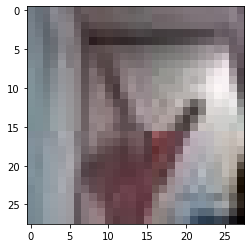

In [6]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 이미지를 resize하는 이유는 무엇일까?
가위바위보 분류기를 만들기 전에, 노드에서 숫자를 분류하는 예제를 학습했다.
숫자를 분류하는 예제에서는 이미지의 크기가 (28 X 28) 이었다.
숫자 이미지는 28 X 28에서도 충분히 숫자를 알아보기 쉬웠고, 흑백 이미지였기 때문에 분류가 쉬운 편이라고 생각한다.
하지만 가위바위보 데이터 이미지의 경우, (28 X 28)로 resize 한 결과를 보면, 정확하게 분류하기 힘들다고 생각된다.
위 이미지만 보더라도, 언뜻 보면 가위가 아니라 바위처럼 보인다.
resize를 하지 않고, 기존 이미지 크기 그대로 사용하면 안 될까?
---
현 시점에서, resize의 의미가 수행시간의 단축이라고 생각된다. 그렇다면, (28 X 28)의 크기로 줄이는 것이 가장 효율적일까?

# 2. 모델 생성 및 학습

In [7]:
n_channel_1 = 32
n_channel_2 = 64
n_dense = 64
n_train_epoch = 10

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3, 3), activation = 'relu', input_shape = (28, 28, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(n_channel_2, (3, 3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation = 'relu'))
model.add(keras.layers.Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

### 가위바위보를 인식하는 딥러닝 네트워크 설계

* 이미지의 특징 수를 32, 64로 설정
* 뉴런의 수를 64로 설정
* 8개의 층으로 이루어진 model을 구현
* Conv2D: 케라스에서 제공하는 Convolution 레이어로, 영상 처리에 주로 사용
* MaxPool2D: Convolution 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만듬. 이를 통해서, 지역적인 사소한 변화가 영향을 미치지 않도록 함
* MaxPooling2D: MaxPool2D와 이름만 다를 뿐, 같은 기능을 수행
* Flatten: 영상을 1차원으로 변환

In [8]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_norm, y_train, epochs = n_train_epoch)

Epoch 1/10
141/141 [==============================] - 7s 20ms/step - loss: 1.0410 - accuracy: 0.4299
Epoch 2/10
141/141 [==============================] - 1s 4ms/step - loss: 0.6534 - accuracy: 0.7312
Epoch 3/10
141/141 [==============================] - 1s 4ms/step - loss: 0.4065 - accuracy: 0.8505
Epoch 4/10
141/141 [==============================] - 1s 4ms/step - loss: 0.3069 - accuracy: 0.8915
Epoch 5/10
141/141 [==============================] - 1s 4ms/step - loss: 0.2062 - accuracy: 0.9329
Epoch 6/10
141/141 [==============================] - 1s 4ms/step - loss: 0.1599 - accuracy: 0.9461
Epoch 7/10
141/141 [==============================] - 1s 4ms/step - loss: 0.1365 - accuracy: 0.9546
Epoch 8/10
141/141 [==============================] - 1s 4ms/step - loss: 0.1258 - accuracy: 0.9555
Epoch 9/10
141/141 [==============================] - 1s 4ms/step - loss: 0.0757 - accuracy: 0.9783
Epoch 10/10
141/141 [==============================] - 1s 4ms/step - loss: 0.0788 - accuracy: 0.976

### 딥러닝 네트워크 학습
* optimizer는 학습에서 실제로 파라미터를 갱신시키는 부분을 의미
* adam(Adaptive Moment Estimation): 현재 가장 자주 사용되는 optimizer로, 다른 optimizer들의 장점을 취해 만든 optimizer
* loss는 loss function을 의미
* sparse_categorical_crossentropy: 다중 분류 손실 함수

# 3. Test set을 이용한 모델 평가

In [9]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


* test set 이미지 크기 변경 (28 X 28)

In [10]:
def load_test_data(img_path, number_of_data = 300):
    img_size = 28
    color = 3
    
    imgs = np.zeros(number_of_data * img_size * img_size * color, dtype = np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype = np.int32)
    
    idx = 0
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 0
        idx = idx + 1
    
    for file in glob.iglob(img_path + '/rock/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 1
        idx = idx + 1
        
    for file in glob.iglob(img_path + '/paper/*.jpg'):
        img = np.array(Image.open(file), dtype = np.int32)
        imgs[idx,:,:,:] = img
        labels[idx] = 2
        idx = idx + 1
        
    print("테스트데이터(x_test)의 이미지 개수는", idx, "입니다.")
    return imgs, labels

## load_test_data(img_path, number_of_data=300)
* 이전에 만들었던 load_data 함수와 같은 내용
* test set의 이미지를 불러오는 기능

In [11]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test) = load_test_data(image_dir_path)
x_test_norm = x_test / 255.0

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

테스트데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


## load_test_data 함수를 이용하여 test set 만들기

* test set을 저장하고, 이미지의 픽셀 값을 0 ~ 1 사이의 값으로 정규화

In [12]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {}".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 1s - loss: 0.9623 - accuracy: 0.7433
test_loss: 0.9623026251792908
test_accuracy: 0.7433333396911621


* verbose: 상세한 logging을 출력할지를 조절하는 parameter
* verbose=0: silent, verbose=1: progress bar, verbose=2: one line per epoch
* verbose 값이 0보다 크면 로그를 출력하게되기 때문에, 실행 속도에 영향을 줄 수 있음
---
* test set을 이용하여, 위에서 훈련시킨 model을 평가
* model의 loss와 accuracy를 측정
* 300개의 training set으로 학습했을때, test_loss: 1.9043, test_accuracy: 0.3333
* 600개의 training set으로 학습했을때, test_loss: 2.0036, test_accuracy: 0.4333
* 900개의 training set으로 학습했을때, test_loss: 1.1084, test_accuracy: 0.6033
* 1200개의 training set으로 학습했을때, test_loss: 1.6996, test_accuracy: 0.5300
* 1500개의 training set으로 학습했을때, test_loss: 1.5470, test_accuracy: 0.6433
* 4500개의 training set으로 학습했을때, test_loss: 0.9623, test_accuracy: 0.7433

-----

# 4. 결론

### * 모델의 정확도는 약 74%

### * 모델 성능 향상을 위한 시도
    1. Training set의 수를 300개부터 1500개까지, 300개씩 늘려가면서 학습시켰음. training set이 많을수록 accuracy가 증가하다가, 다시 감소하다가 1500개의 training set에서 다시 증가하는 경향을 보였음. 이는 학습 데이터의 양이 많을수록 좋은 것은 사실이나, 학습 데이터의 질도 무시하지 못한다는 것을 의미한다고 생각함. 이후, training set의 양을 1500개에서 4500개로 한번에 늘려서 학습을 진행. 이때도 어느정도 정확한 사진들로 이루어진 training set을 만들기 위해서, 이미지들을 확인하면서 training set에 추가함. 그 결과, 약 74%의 정확도를 측정.
    2. Test set도 중요한 영향을 미친다고 생각했기에 퀄리티가 좋은 test set 확보를 위해서, data set을 확인해보고 손모양이 비교적 정확한 data set으로 선정.
    3. Hyperparameter 또한 바꿔가면서 학습을 진행함. 물론, hyerparameter도 중요하지만, hyperparameter에 따른 정확도를 비교했을때, training set의 크기나 test set의 질 보다는 중요성이 낮다고 판단.

# 5. 추가적인 분석

## 모델을 어떻게 학습시켜야 하는가?
* 적절한 hyperparameter를 찾는 것은 중요하지만, hyperparameter의 변화로 인한 accuracy의 증가는 한계가 있음
* 적절한 hyperparameter를 찾는 것 보다는, 질 좋은 training set을 많이 확보하는 것이 중요하다고 느꼈음
* 900개의 training set을 이용하여 학습한 경우, accuracy가 0.6033이었지만, 1200개의 training set을 이용하여 학습한 경우, accuracy가 0.5300으로 감소하였음
* 그러나, training set을 1500개로 증가했을때, accuracy가 0.6433으로 다시 증가했기 때문에, training set의 크기로 인해서 accuracy가 감소한 것은 아님.
* 따라서, 이미지의 퀄리티(손모양의 정확도)가 accuracy에 영향을 미쳤다고 판단.
* 결과적으로, training set을 구성할 때, 최대한 많은 이미지를 사용하여 구성하는 것도 중요하지만, training set을 구성하는 이미지들의 퀄리티 또한 중요하다고 판단.

## 이미지 크기에 따른 accuracy의 변화 (1500개의 이미지 training set 기준)
* 기존의 (28 X 28) 이미지가 아닌 (128 X 128) 크기의 이미지를 이용하여 학습한 경우, accuracy: 0.5067
* (224 X 224) 크기의 이미지로 학습한 경우, accuracy: 0.4633
* 이미지의 크기가 커질수록, 학습에 소요되는 시간이 증가하였음
* 그러나 이미지의 크기가 커질수록, accuracy가 감소하는 경향을 보였음
* 따라서 이미지의 크기가 크다고해서 무조건적인 accuracy의 증가로 이루어지는 것은 아니라고 판단
* 해당 예제에서는 이미지의 크기가 커질수록 accuracy가 감소한다고 보여지지만, 표본이 적기에 무조건적으로 감소한다고 판단하기에는 어려움
* 이미지의 크기보단, **질** 좋은 training set을 **많이** 이용하여 학습하는 것이 모델의 accuracy를 확실하게 증가시킬 수 있다고 판단